In [32]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [33]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
import argparse
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense

import matplotlib.pyplot as plt

In [34]:
trainf = pd.read_csv('/kaggle/input/hackerearth-holiday-season/dataset/train.csv')
print('Train shape is : ',trainf.shape)
trainf.head()
labels=len(trainf.Class.unique())
labels

Train shape is :  (6469, 2)


6

In [35]:
trainf.Class.value_counts()

Miscellaneous     2801
Christmas_Tree    1539
Jacket             640
Candle             593
Airplane           535
Snowman            361
Name: Class, dtype: int64

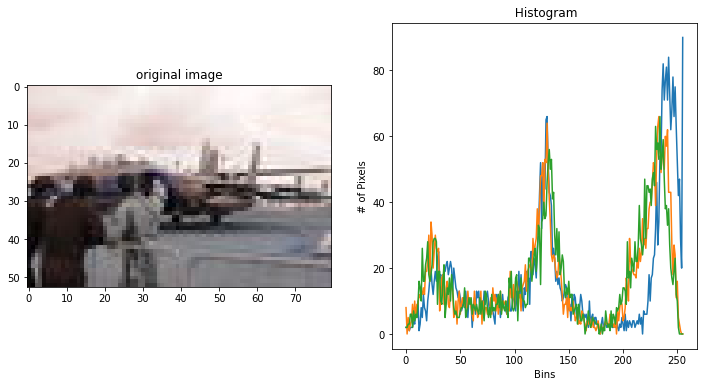

In [36]:
#Reading the image and plotting the image and the histograms of the RGB channels
imag=cv2.imread('../input/hackerearth-holiday-season/dataset/train/image2.jpg')
#gray = cv2.cvtColor(imag, cv2.COLOR_BGR2GRAY)
#hist = cv2.calcHist([gray], [0], None, [256], [0, 256])

histr = cv2.calcHist([imag],[0],None,[256],[0,256]) 
histg = cv2.calcHist([imag],[1],None,[256],[0,256]) 
histb = cv2.calcHist([imag],[2],None,[256],[0,256]) 
    
fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_size_inches(6*2, 3*2)

ax1.set_title('original image')
ax1.imshow(imag)
ax2.set_title(" Histogram")
ax2.set_xlabel("Bins")
ax2.set_ylabel("# of Pixels")
ax2.plot(histr)
ax2.plot(histg)
ax2.plot(histb)


#plt.xlim([0, 256])
plt.show()

### Shuffling the images b4 and creating partition dictionary for train and validation

In [37]:
## Shuffling the images b4 reading the images
train_data_dir = '../input/hackerearth-holiday-season/dataset/train/'
traindataids=os.listdir(train_data_dir)
traindataids=[g for g in traindataids if '.jpg' in g ] #To avoid the non jpeg file present in the directory
import random 
random.shuffle(traindataids)
partition={}
train_ids=random.sample(traindataids,int(.9*len(traindataids)))
val_ids= [id for id in traindataids if id not in train_ids ]

In [38]:
print('First 10 images : ',train_ids[:10])
print('Length of train set : ', len(train_ids))
print('First 10 images : ',val_ids[:10])
print('Length of val set : ', len(val_ids))

First 10 images :  ['image6860.jpg', 'image3547.jpg', 'image3553.jpg', 'image4101.jpg', 'image767.jpg', 'image194.jpg', 'image8030.jpg', 'image5174.jpg', 'image2587.jpg', 'image7141.jpg']
Length of train set :  5822
First 10 images :  ['image7067.jpg', 'image5112.jpg', 'image219.jpg', 'image6173.jpg', 'image4681.jpg', 'image8593.jpg', 'image6740.jpg', 'image2768.jpg', 'image1610.jpg', 'image2062.jpg']
Length of val set :  647


In [39]:
partition['train'] =train_ids
partition['validation'] =val_ids
partition

{'train': ['image6860.jpg',
  'image3547.jpg',
  'image3553.jpg',
  'image4101.jpg',
  'image767.jpg',
  'image194.jpg',
  'image8030.jpg',
  'image5174.jpg',
  'image2587.jpg',
  'image7141.jpg',
  'image6444.jpg',
  'image5645.jpg',
  'image2470.jpg',
  'image8995.jpg',
  'image8380.jpg',
  'image9724.jpg',
  'image6109.jpg',
  'image2191.jpg',
  'image6521.jpg',
  'image7507.jpg',
  'image8345.jpg',
  'image78.jpg',
  'image9862.jpg',
  'image1338.jpg',
  'image3708.jpg',
  'image983.jpg',
  'image4430.jpg',
  'image2204.jpg',
  'image697.jpg',
  'image9284.jpg',
  'image5319.jpg',
  'image6968.jpg',
  'image5902.jpg',
  'image4510.jpg',
  'image5963.jpg',
  'image9261.jpg',
  'image3692.jpg',
  'image5591.jpg',
  'image4936.jpg',
  'image9400.jpg',
  'image8140.jpg',
  'image3410.jpg',
  'image9242.jpg',
  'image6424.jpg',
  'image2070.jpg',
  'image4046.jpg',
  'image6087.jpg',
  'image9090.jpg',
  'image7874.jpg',
  'image2109.jpg',
  'image1980.jpg',
  'image9733.jpg',
  'image7

In [40]:
list_IDs=traindataids

In [43]:
trainf.head()

,Image,Class
0,image3476.jpg,Miscellaneous
1,image5198.jpg,Candle
2,image4183.jpg,Snowman
3,image1806.jpg,Miscellaneous
4,image7831.jpg,Miscellaneous


In [44]:
partition.keys()

dict_keys(['train', 'validation'])

### Shuffling the images b4 and creating partition dictionary for train and validation

In [45]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

### train and valid
partition.keys()
# trainf['labelstr'] = trainf['category'].apply(lambda x : str(x)) # This is required because image data generator shd know it's a class and not a number

train_df=trainf[trainf['Image'].isin(partition['train'])]
valid_df=trainf[trainf['Image'].isin(partition['validation'])]

print(train_df.shape,valid_df.shape)

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
print(train_datagen)

# In below case we are getting data from dataframe, similarly we can take it from directory with a list of the values mapping the image and categ
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=train_data_dir,
        x_col="Image",
        y_col='Class',
        target_size=(224,224),
        batch_size=32,
        class_mode='categorical') #categorical for multi class o/p's

# We are not doing augmentation in validation data thinking it's a test data as we don't augment the test data in reality
valid_datagen = ImageDataGenerator(rescale=1./255)
print(valid_datagen)

validation_generator = valid_datagen.flow_from_dataframe(
        dataframe=valid_df,
        directory=train_data_dir,
        x_col="Image",
        y_col='Class',
        target_size=(224,224),
        batch_size=32,
        class_mode='categorical') #categorical for multi class o/p's

(5822, 2) (647, 2)
Found 5822 validated image filenames belonging to 6 classes.
Found 647 validated image filenames belonging to 6 classes.


In [47]:
#Creating a Deep Neural Network 
from keras.layers import BatchNormalization, Dropout

def deep_cnn_advanced(nclass):
    model = Sequential()
    
    model.add(Conv2D(input_shape = (224,224,3), filters = 50, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(filters = 50, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Conv2D(filters = 50, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(filters = 50, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Conv2D(filters = 50, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(filters = 50, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    # prior layer should be flattend to be connected to dense layers
    model.add(Flatten())
    # dense layer with 50 neurons
    model.add(Dense(50, activation = 'relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.5))
    # final layer with 10 neurons to classify the instances
    model.add(Dense(nclass, activation = 'softmax', kernel_initializer='he_normal'))
    
    #adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    return model    

In [49]:
Dcnn = deep_cnn_advanced(6)
Dcnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 224, 224, 50)      1400      
_________________________________________________________________
batch_normalization_6 (Batch (None, 224, 224, 50)      200       
_________________________________________________________________
activation_16 (Activation)   (None, 224, 224, 50)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 224, 224, 50)      22550     
_________________________________________________________________
batch_normalization_7 (Batch (None, 224, 224, 50)      200       
_________________________________________________________________
activation_17 (Activation)   (None, 224, 224, 50)      0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 112, 112, 50)     

In [50]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [51]:
!pip install livelossplot

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


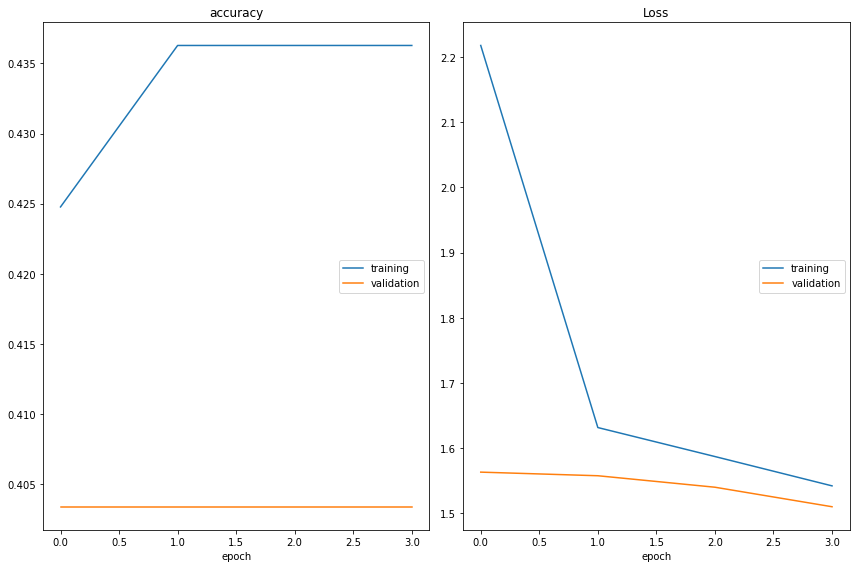

accuracy
	training         	 (min:    0.425, max:    0.436, cur:    0.436)
	validation       	 (min:    0.403, max:    0.403, cur:    0.403)
Loss
	training         	 (min:    1.542, max:    2.218, cur:    1.542)
	validation       	 (min:    1.510, max:    1.563, cur:    1.510)
182/182 [==============================] - 82s 449ms/step - loss: 1.5419 - accuracy: 0.4363 - val_loss: 1.5099 - val_accuracy: 0.4034


In [52]:
from livelossplot.keras import PlotLossesCallback
from keras.callbacks import CSVLogger
TRAINING_LOGS_FILE = "./training_logs.csv"
Dcnn.fit_generator(generator=train_generator,
                    validation_data=validation_generator,epochs = 4,
                    callbacks=[PlotLossesCallback(), CSVLogger(TRAINING_LOGS_FILE,append=False,separator=";")])